# Creating Input Layer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
os.chdir('/content/drive/My Drive/CS 230: Deep Learning/stability-flexibility-tradeoff-master/Participant Data')
df_exp_1 = pd.read_csv('Experiment 1/combinedData_Exp1.csv')
!ls

'Experiment 1'	'Experiment 2'	'Experiment 3'


In [ ]:
# Assuming df_exp_1 is your existing DataFrame
# Filter the DataFrame to include only rows where expStage is 'task' and sectionType is 'mainTask'
df_exp_1_task = df_exp_1[(df_exp_1['expStage'] == 'task') & (df_exp_1['sectionType'] == 'mainTask')].copy()

# Add previous stimulus and taskCue columns
df_exp_1_task.loc[:, 'prev_stimulus'] = df_exp_1_task['stimulus'].shift(1)
df_exp_1_task.loc[:, 'prev_taskCue'] = df_exp_1_task['taskCue'].shift(1)


# Select only the useful columns
df_exp_1_input = df_exp_1_task[['stimulus', 'taskCue', 'prev_stimulus', 'stimCongruency', 'switchType', 'prev_taskCue', 'acc', 'RT']]
df_exp_1_input_acc_only = df_exp_1_input[df_exp_1_input['acc'] == 1]


In [ ]:
# removing first trial from every block
df_exp_1_input_acc_only = df_exp_1_input_acc_only[df_exp_1_input_acc_only['switchType'] != 'n']


In [ ]:
df_exp_1_input_acc_only

,stimulus,taskCue,prev_stimulus,stimCongruency,switchType,prev_taskCue,acc,RT
78,2.0,m,1.0,c,r,m,1.0,938.0
79,1.0,p,2.0,i,s,m,1.0,748.0
80,3.0,m,1.0,i,s,p,1.0,966.0
81,6.0,m,3.0,i,r,m,1.0,848.0
82,3.0,p,6.0,i,s,m,1.0,1092.0
...,...,...,...,...,...,...,...,...
40276,7.0,p,4.0,i,s,m,1.0,726.0
40277,9.0,m,7.0,i,s,p,1.0,733.0
40278,6.0,p,9.0,c,s,m,1.0,622.0
40279,7.0,p,6.0,i,r,p,1.0,599.0


*italicized text*# Neural Network Model #1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Selecting relevant features and target
features = ['stimulus', 'taskCue', 'prev_stimulus', 'prev_taskCue', 'stimCongruency', 'switchType']
target = 'RT'

In [ ]:
# Divide into input and output
X = df_exp_1_input_acc_only[features].copy()
y = df_exp_1_input_acc_only[target].values

# # Identify numeric and categorical columns
# numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
# categorical_cols = X.select_dtypes(exclude=['float64', 'int64']).columns

# # One-hot encode categorical columns
# X_encoded = pd.get_dummies(X, columns=categorical_cols)




In [ ]:
task_cols= ['taskCue', 'prev_taskCue']  # specify the columns you want to map
task_mapping = {'m': 0, 'p': 1}

X[task_cols] = X[task_cols].applymap(lambda x: task_mapping.get(x, x))
X['stimCongruency'] = X['stimCongruency'].map({'i': 0, 'c': 1})
X['switchType'] = X['switchType'].map({'r': 0, 's': 1})
X

<ipython-input-9-46b5158313f7>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X[task_cols] = X[task_cols].applymap(lambda x: task_mapping.get(x, x))


,stimulus,taskCue,prev_stimulus,prev_taskCue,stimCongruency,switchType
78,2.0,0,1.0,0,1,0
79,1.0,1,2.0,0,0,1
80,3.0,0,1.0,1,0,1
81,6.0,0,3.0,0,0,0
82,3.0,1,6.0,0,0,1
...,...,...,...,...,...,...
40276,7.0,1,4.0,0,0,1
40277,9.0,0,7.0,1,0,1
40278,6.0,1,9.0,0,1,1
40279,7.0,1,6.0,1,0,0


In [ ]:
# # Normalize features
# scaler = StandardScaler()
# X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

# # Ensure data is in float32 format for PyTorch
# X_processed = X_encoded.values.astype(np.float32)
# y_processed = y.astype(np.float32)

X_processed = X.values.astype(np.float32)
y_processed = y.astype(np.float32)/1000

In [ ]:
X_processed

array([[2., 0., 1., 0., 1., 0.],
       [1., 1., 2., 0., 0., 1.],
       [3., 0., 1., 1., 0., 1.],
       ...,
       [6., 1., 9., 0., 1., 1.],
       [7., 1., 6., 1., 0., 0.],
       [9., 0., 7., 1., 0., 1.]], dtype=float32)

In [ ]:
X_processed.shape

(29538, 6)

In [ ]:
y_processed

array([0.938, 0.748, 0.966, ..., 0.622, 0.599, 0.925], dtype=float32)

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.1, random_state=42)

X_train


array([[3., 1., 6., 1., 1., 0.],
       [7., 0., 8., 1., 0., 1.],
       [6., 1., 1., 0., 0., 1.],
       ...,
       [8., 0., 4., 0., 1., 0.],
       [1., 1., 3., 0., 1., 1.],
       [1., 0., 8., 1., 1., 1.]], dtype=float32)

In [ ]:
X_test.shape

(2954, 6)

In [ ]:
y_train

array([0.589, 1.02 , 0.867, ..., 0.745, 1.039, 0.636], dtype=float32)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)


torch.Size([26584, 6]) torch.Size([2954, 6]) torch.Size([26584]) torch.Size([2954])


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Define a 6-layer neural network with ReLU activations between layers
        self.layer1 = nn.Linear(6, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.layer5 = nn.Linear(32, 16)
        self.layer6 = nn.Linear(16, 1)  # Output layer for a single numerical value

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x = self.layer6(x)
        return x

In [ ]:
model = NeuralNetwork()
criterion = nn.MSELoss() # Mean squared error loss for regression
# # Define the loss function as MAE (L1 Loss)
# criterion = nn.L1Loss()  # Mean absolute error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
print(torch.isnan(X_train_tensor).any())
print(torch.isinf(X_train_tensor).any())

# Check for NaNs or Infs in target data
print(torch.isnan(y_train_tensor).any())
print(torch.isinf(y_train_tensor).any())

tensor(False)
tensor(False)
tensor(False)
tensor(False)


In [ ]:
# Training loop
y_train_tensor = y_train_tensor.view(-1, 1)
loss_history = []
epochs = 1000

for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    loss_history.append(loss.item())

    if (epoch + 1) % 25 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [25/1000], Loss: 0.8708
Epoch [50/1000], Loss: 0.7657
Epoch [75/1000], Loss: 0.5986
Epoch [100/1000], Loss: 0.3547
Epoch [125/1000], Loss: 0.1275
Epoch [150/1000], Loss: 0.0983
Epoch [175/1000], Loss: 0.0913
Epoch [200/1000], Loss: 0.0856
Epoch [225/1000], Loss: 0.0805
Epoch [250/1000], Loss: 0.0760
Epoch [275/1000], Loss: 0.0716
Epoch [300/1000], Loss: 0.0676
Epoch [325/1000], Loss: 0.0634
Epoch [350/1000], Loss: 0.0595
Epoch [375/1000], Loss: 0.0563
Epoch [400/1000], Loss: 0.0535
Epoch [425/1000], Loss: 0.0511
Epoch [450/1000], Loss: 0.0494
Epoch [475/1000], Loss: 0.0480
Epoch [500/1000], Loss: 0.0470
Epoch [525/1000], Loss: 0.0464
Epoch [550/1000], Loss: 0.0461
Epoch [575/1000], Loss: 0.0459
Epoch [600/1000], Loss: 0.0457
Epoch [625/1000], Loss: 0.0456
Epoch [650/1000], Loss: 0.0455
Epoch [675/1000], Loss: 0.0454
Epoch [700/1000], Loss: 0.0453
Epoch [725/1000], Loss: 0.0453
Epoch [750/1000], Loss: 0.0452
Epoch [775/1000], Loss: 0.0452
Epoch [800/1000], Loss: 0.0452
Epoch [825/

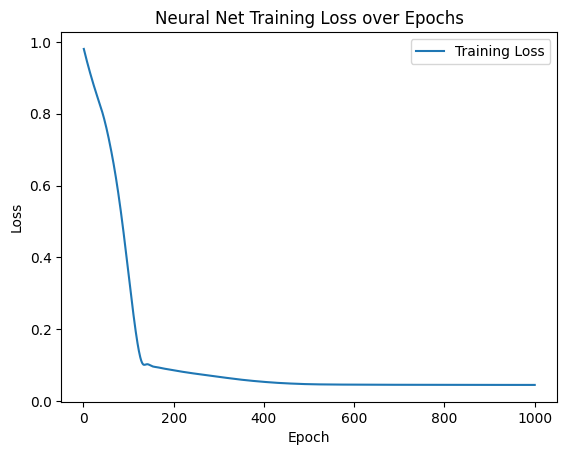

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Net Training Loss over Epochs')
plt.legend()
plt.show()

Test Loss: 0.0452


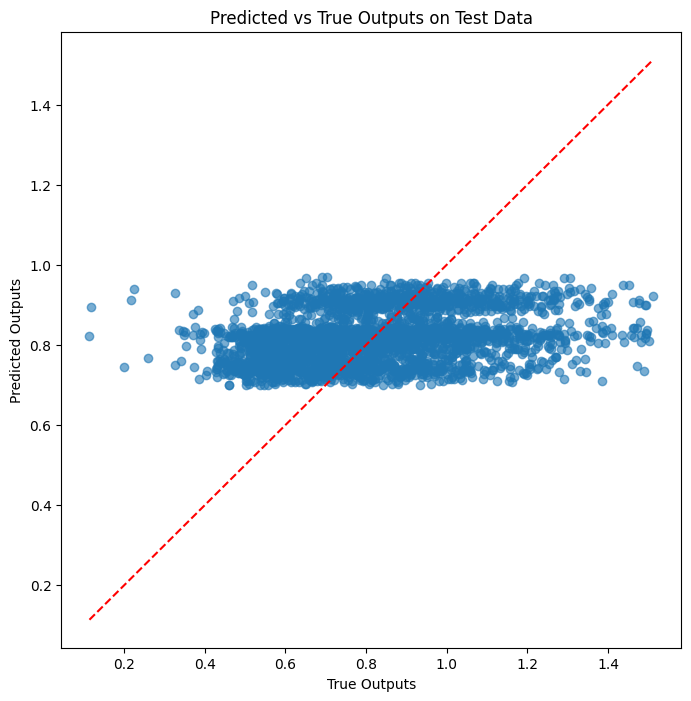

In [ ]:
y_test_tensor = y_test_tensor.view(-1, 1)

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

y_test = y_test_tensor.numpy()
predictions = test_outputs.numpy()

# Scatter plot of the predicted outputs vs. true outputs
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x for reference
plt.xlabel('True Outputs')
plt.ylabel('Predicted Outputs')
plt.title('Predicted vs True Outputs on Test Data')
plt.show()


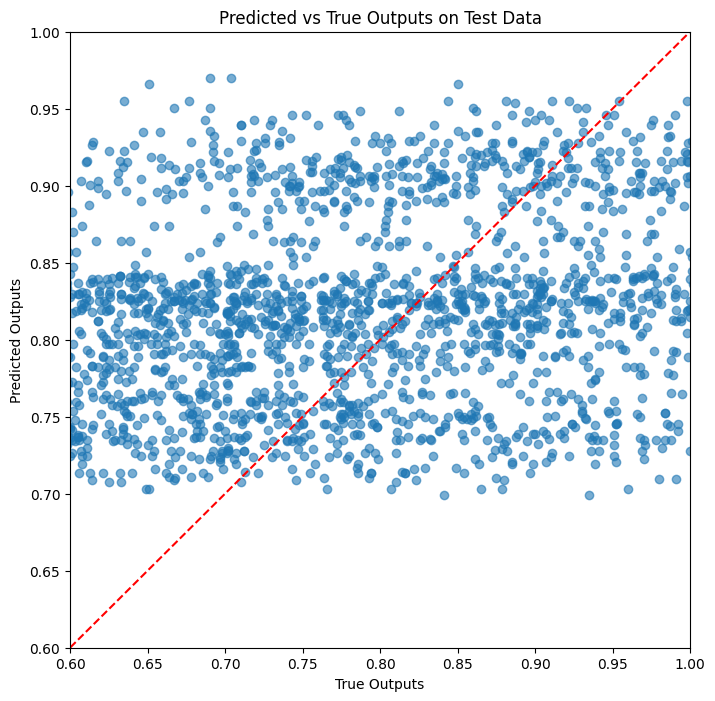

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x for reference
plt.xlim(0.6, 1.0)  # Limit x-axis between 0.6 and 0.8
plt.ylim(0.6, 1.0)  # Limit x-axis between 0.6 and 0.8
plt.xlabel('True Outputs')
plt.ylabel('Predicted Outputs')
plt.title('Predicted vs True Outputs on Test Data')
plt.show()

In [ ]:
# Calculate means
x = y_test*1000
y = predictions*1000
mean_x = np.mean(x)
mean_y = np.mean(y)

# Compute covariance manually
cov = (np.sum((x - mean_x) * (y - mean_y)) / (len(x) - 1))

In [ ]:
std_x = np.std(x, ddof=1)
std_y = np.std(y, ddof=1)
print(std_x)
print(std_y)

221.5966
62.86111


In [ ]:
print("Correlation coefficient: ", (cov/(std_x*std_y)))

Correlation coefficient:  0.28063865900369944
